In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

# Resolve project root safely
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Define path
FEATURES_PATH = BASE_DIR / "data" / "processed" / "features.parquet"

# Load features
X = pd.read_parquet(FEATURES_PATH)
X_sample = X.sample(200_000, random_state=42)


In [2]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=200,
    max_samples="auto",
    contamination=0.01,   # start with 1%
    random_state=42,
    n_jobs=-1
)

iso.fit(X_sample)


,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",200
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.01
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [3]:
anomaly_scores = -iso.score_samples(X)


In [4]:
scores_df = X.copy()
scores_df["anomaly_score"] = anomaly_scores


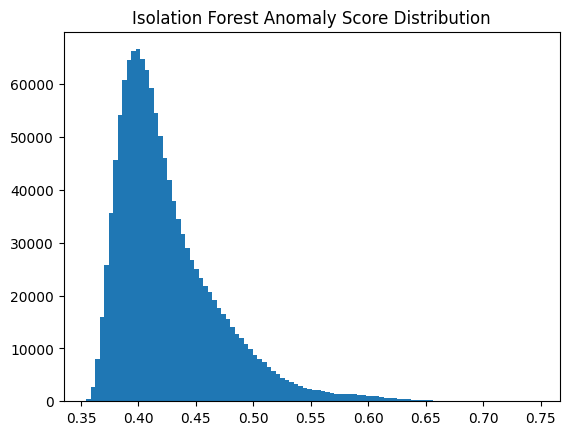

In [5]:
import matplotlib.pyplot as plt

plt.hist(anomaly_scores, bins=100)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.show()


In [6]:
threshold = np.percentile(anomaly_scores, 99)  # top 1%

scores_df["is_anomaly"] = anomaly_scores >= threshold


In [7]:
scores_df["is_anomaly"].mean()


np.float64(0.010000192800817476)

In [9]:
from pathlib import Path
import joblib

# Resolve project root safely
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Define models directory
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Define model path
MODEL_PATH = MODELS_DIR / "isolation_forest_v1.joblib"

# Save model
joblib.dump(iso, MODEL_PATH)


['/home/caleb/transaction-anomaly-ml/models/isolation_forest_v1.joblib']

In [10]:
from pathlib import Path

# Resolve project root safely
BASE_DIR = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Define processed data directory
PROCESSED_DIR = BASE_DIR / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Define output path
SCORES_PATH = PROCESSED_DIR / "iforest_scores.csv"

# Save scores
scores_df[["anomaly_score", "is_anomaly"]].to_csv(
    SCORES_PATH,
    index=False
)


In [11]:
for c in [0.005, 0.01, 0.02]:
    iso = IsolationForest(contamination=c, random_state=42, n_jobs=-1)
    iso.fit(X_sample)
    scores = -iso.score_samples(X)
    print(c, (scores >= np.percentile(scores, 100*(1-c))).mean())


0.005 0.005000482002043689
0.01 0.010000192800817476
0.02 0.020000385601634953
